In [38]:
# Import all necessary libraries.
import numpy as np
import pandas as pd
from sklearn  import preprocessing
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import seaborn as sns
sns.set_theme()

In [39]:
# Hyper parameters
########
num_of_feature = 4 # number of input features for LSTM and GRU network
past_observation = 6 # Number of past hours data used as input to the LSTM and GRU network
##########

######## Model Parameters # 
hidden_layers_unit = [128, 64,32,16]
return_sequence = [True, True, True,False]
batch_size = 64
num_of_epoch = 100



# Read dataset

In [40]:
# Import Dataset

traffic_data = pd.read_csv("dataset/Metro_Interstate_Traffic_Volume.csv")
traffic_data = traffic_data.set_index(pd.DatetimeIndex(traffic_data['date_time'])).rename(columns={"date_time": "ds"})
traffic_data['ds'] = pd.to_datetime(traffic_data['ds'],infer_datetime_format=True)

In [41]:
traffic_data

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,ds,traffic_volume
date_time,,,,,,,,,
2012-10-02 09:00:00,None,288.28,0.0,0.0,40,Clouds,scattered clouds,2012-10-02 09:00:00,5545
2012-10-02 10:00:00,None,289.36,0.0,0.0,75,Clouds,broken clouds,2012-10-02 10:00:00,4516
2012-10-02 11:00:00,None,289.58,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 11:00:00,4767
2012-10-02 12:00:00,None,290.13,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 12:00:00,5026
2012-10-02 13:00:00,None,291.14,0.0,0.0,75,Clouds,broken clouds,2012-10-02 13:00:00,4918
...,...,...,...,...,...,...,...,...,...
2018-09-30 19:00:00,None,283.45,0.0,0.0,75,Clouds,broken clouds,2018-09-30 19:00:00,3543
2018-09-30 20:00:00,None,282.76,0.0,0.0,90,Clouds,overcast clouds,2018-09-30 20:00:00,2781
2018-09-30 21:00:00,None,282.73,0.0,0.0,90,Thunderstorm,proximity thunderstorm,2018-09-30 21:00:00,2159


In [42]:
traffic_data = traffic_data.drop_duplicates()

In [43]:
# Checking for any missing or empty value
traffic_data.isna().sum()

holiday                0
temp                   0
rain_1h                0
snow_1h                0
clouds_all             0
weather_main           0
weather_description    0
ds                     0
traffic_volume         0
dtype: int64

# convert categorical to nominal data

In [44]:
# Convert categorical value to numerical values. For holiday attribute, value will be within by 0 and 1. If it is holiday then 1 otherwise 0
label_encoder = preprocessing.LabelEncoder()
traffic_data['holiday'] = np.where(traffic_data.holiday=='None',0,1).astype('int64')
traffic_data['weather_main'] = label_encoder.fit_transform(traffic_data['weather_main'])
traffic_data['weather_description'] = label_encoder.fit_transform(traffic_data['weather_description'])

C:\Users\Won's Lab\AppData\Local\Temp\ipykernel_27312\1522180088.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  traffic_data['holiday'] = np.where(traffic_data.holiday=='None',0,1).astype('int64')
C:\Users\Won's Lab\AppData\Local\Temp\ipykernel_27312\1522180088.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  traffic_data['weather_main'] = label_encoder.fit_transform(traffic_data['weather_main'])
C:\Users\Won's Lab\AppData\Local\Temp\ipykernel_27312\1522180088.py:5: SettingWithCopyWarning: 
A value 

In [45]:
traffic_data.describe()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,traffic_volume
count,48187.000000,48187.000000,48187.000000,48187.000000,48187.000000,48187.000000,48187.000000,48187.000000
mean,0.001266,281.204995,0.334382,0.000222,49.365451,2.578642,16.540021,3259.618134
std,0.035557,13.338738,44.797033,0.008169,39.015213,2.784148,8.969561,1986.954465
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,272.160000,0.000000,0.000000,1.000000,0.000000,10.000000,1192.500000
50%,0.000000,282.450000,0.000000,0.000000,64.000000,1.000000,17.000000,3379.000000
75%,0.000000,291.806000,0.000000,0.000000,90.000000,5.000000,27.000000,4933.000000
max,1.000000,310.070000,9831.300000,0.510000,100.000000,10.000000,37.000000,7280.000000


<AxesSubplot:xlabel='date_time'>

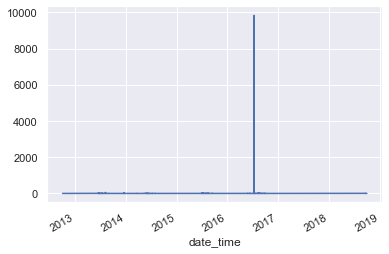

In [46]:
#traffic_data['temp'].plot()
traffic_data['rain_1h'].plot()


<AxesSubplot:xlabel='date_time'>

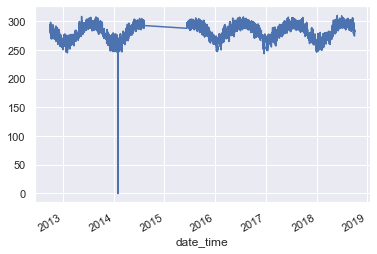

In [47]:
traffic_data['temp'].plot()

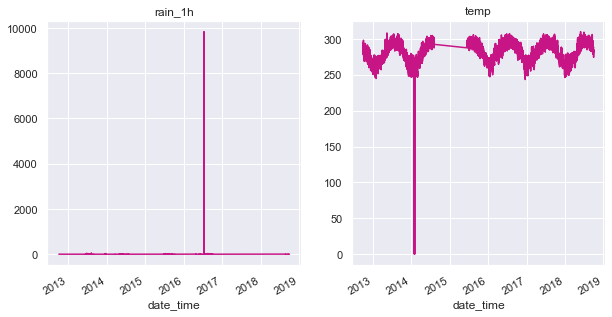

In [48]:
df1 = traffic_data['rain_1h']
df2 = traffic_data['temp']
#define number of rows and columns for subplots
nrow=1
ncol=2

# make a list of all dataframes 
df_list = [df1 ,df2]
df_title= ['rain_1h','temp']
fig, axes = plt.subplots(nrow, ncol, figsize=(10,5))
i = 0
for x in axes.flatten():
  df_list[i].plot(ax=x, color='mediumvioletred')
  x.set_title(df_title[i])
  i += 1
plt.savefig("reduced_feature_images/with_outlier.png", dpi=1200)

In [49]:
Q1 = traffic_data.quantile(0.25)
Q3 = traffic_data.quantile(0.75)
IQR = Q3 - Q1
print(IQR)

holiday                   0.000
temp                     19.646
rain_1h                   0.000
snow_1h                   0.000
clouds_all               89.000
weather_main              5.000
weather_description      17.000
traffic_volume         3740.500
dtype: float64


In [50]:
traffic_data=traffic_data[~((traffic_data['temp'] <(Q1['temp']-1.5*IQR['temp'])) | (traffic_data['temp'] >(Q1['temp']+1.5*IQR['temp'])))]
traffic_data=traffic_data[~((traffic_data['traffic_volume'] <(Q1['traffic_volume']-1.5*IQR['traffic_volume'])) | (traffic_data['traffic_volume'] >(Q1['traffic_volume']+1.5*IQR['traffic_volume'])))]

# Prepare training and testing data

<AxesSubplot:xlabel='date_time'>

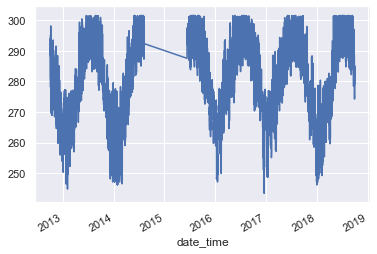

In [51]:
# ploting traffic data to see to see any data imbalance
traffic_data['temp'].plot()

<AxesSubplot:xlabel='date_time'>

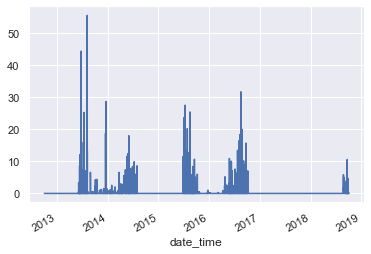

In [52]:
traffic_data['rain_1h'].plot()

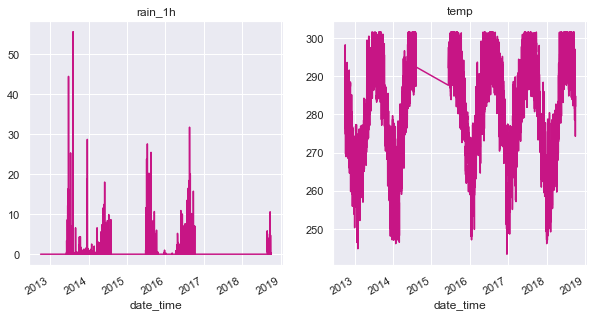

In [53]:
df1 = traffic_data['rain_1h']
df2 = traffic_data['temp']
#define number of rows and columns for subplots
nrow=1
ncol=2

# make a list of all dataframes 
df_list = [df1 ,df2]
df_title= ['rain_1h','temp']
fig, axes = plt.subplots(nrow, ncol, figsize=(10,5))
i = 0
for x in axes.flatten():
  df_list[i].plot(ax=x, color='mediumvioletred')
  x.set_title(df_title[i])
  i += 1
plt.savefig("reduced_feature_images/without_outlier.png", dpi=1200)

In [54]:

traffic_data

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,ds,traffic_volume
date_time,,,,,,,,,
2012-10-02 09:00:00,0,288.28,0.0,0.0,40,1,24,2012-10-02 09:00:00,5545
2012-10-02 10:00:00,0,289.36,0.0,0.0,75,1,2,2012-10-02 10:00:00,4516
2012-10-02 11:00:00,0,289.58,0.0,0.0,90,1,19,2012-10-02 11:00:00,4767
2012-10-02 12:00:00,0,290.13,0.0,0.0,90,1,19,2012-10-02 12:00:00,5026
2012-10-02 13:00:00,0,291.14,0.0,0.0,75,1,2,2012-10-02 13:00:00,4918
...,...,...,...,...,...,...,...,...,...
2018-09-30 19:00:00,0,283.45,0.0,0.0,75,1,2,2018-09-30 19:00:00,3543
2018-09-30 20:00:00,0,282.76,0.0,0.0,90,1,19,2018-09-30 20:00:00,2781
2018-09-30 21:00:00,0,282.73,0.0,0.0,90,10,21,2018-09-30 21:00:00,2159


In [55]:
split_date = '2018-01-01'
train_data = traffic_data.loc[traffic_data.index <= split_date].copy()
test_data = traffic_data.loc[traffic_data.index > split_date].copy()

train_time = train_data["ds"]
test_time = test_data["ds"]

In [56]:
train_data = train_data[["temp","rain_1h","clouds_all","traffic_volume"]]
test_data = test_data[["temp","rain_1h","clouds_all","traffic_volume"]]

In [57]:
train_data

,temp,rain_1h,clouds_all,traffic_volume
date_time,,,,
2012-10-02 09:00:00,288.28,0.0,40,5545
2012-10-02 10:00:00,289.36,0.0,75,4516
2012-10-02 11:00:00,289.58,0.0,90,4767
2012-10-02 12:00:00,290.13,0.0,90,5026
2012-10-02 13:00:00,291.14,0.0,75,4918
...,...,...,...,...
2017-12-31 20:00:00,249.79,0.0,5,2731
2017-12-31 21:00:00,249.61,0.0,5,2483
2017-12-31 22:00:00,249.50,0.0,1,2041


In [58]:
test_data

,temp,rain_1h,clouds_all,traffic_volume
date_time,,,,
2018-01-01 01:00:00,249.08,0.0,1,1408
2018-01-01 02:00:00,248.86,0.0,1,931
2018-01-01 03:00:00,248.72,0.0,1,585
2018-01-01 04:00:00,248.43,0.0,1,381
2018-01-01 05:00:00,248.07,0.0,1,434
...,...,...,...,...
2018-09-30 19:00:00,283.45,0.0,75,3543
2018-09-30 20:00:00,282.76,0.0,90,2781
2018-09-30 21:00:00,282.73,0.0,90,2159


In [59]:
def plot_series(time, series, format='-', start=0, end=None):
    plt.plot(time[start:end], series[start:end],format)
    plt.xlabel('Time')
    plt.ylabel('Traffic Volume')
    plt.grid(True)

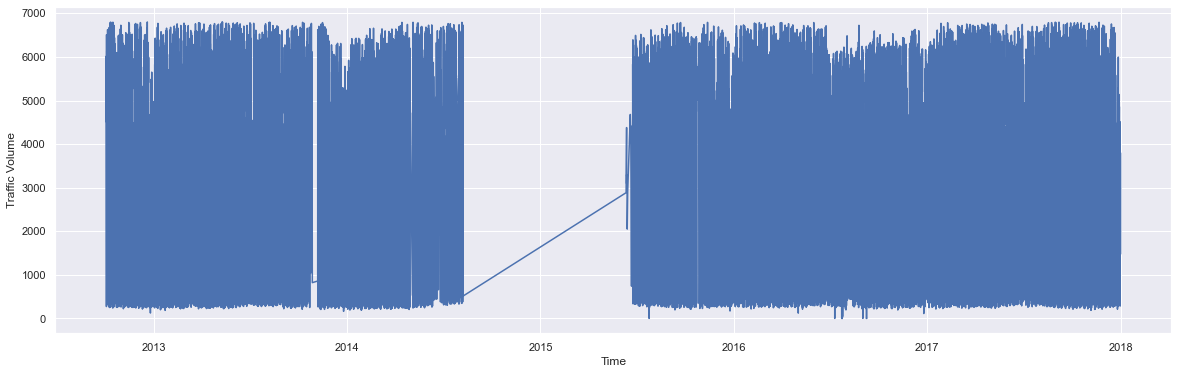

In [60]:
x_train = np.array(train_data['traffic_volume'])
x_valid = np.array(test_data['traffic_volume'])

time_train = np.array(train_time)
time_valid = np.array(test_time)

plt.figure(figsize=(20,6))
plot_series(time_train, x_train)

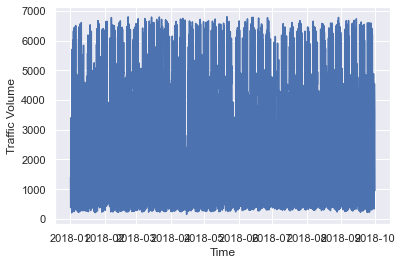

In [61]:
plot_series(time_valid, x_valid)

In [62]:
# Values of the attribute are in different scales. For example, holiday has maximum value 1 and traffic volume let say, 2000. Since these values are totally different range, it might be hurt model learning process. To overcome this issue, we need to do data normalization or standarization.
sc = MinMaxScaler()
sc_test = MinMaxScaler()
training_data_set = sc.fit_transform(train_data)
training_data_frame = pd.DataFrame(training_data_set)
test_data_set = sc_test.fit_transform(test_data)
test_data_frame = pd.DataFrame(test_data_set)


In [63]:
# Make data for the LSTM model. I used past t-hours of data to predict the next 'n' hours data. Here window_size means window size data will be used for predicting next 'n' hours data

def df_to_x_y(data, window_size=5):
    X = []
    y = []
    for i in range(len(data)-window_size):
        row = [r for r in data[i:i+window_size]]
        X.append(row)
        label = data[i+window_size][num_of_feature-1]
        y.append(label)
    return np.array(X), np.array(y)

X, y = df_to_x_y(training_data_set,past_observation)
X.shape, y.shape

((39374, 6, 4), (39374,))

In [64]:
# X test y Test
X_test, y_test = df_to_x_y(test_data_set, past_observation)
X_test.shape, y_test.shape

((7622, 6, 4), (7622,))

In [65]:
# split data into train test and validation datase
from cgi import test


train_length = int(len(X)*0.8) # 80% trainging
validation_length = int(len(X)*.20) # 10% testing and rest for validation
print(train_length, validation_length, (train_length+validation_length))
X_train, y_train = X[:train_length],y[:train_length]
X_val, y_val = X[train_length:], y[train_length:]

35436 3937 39373


In [66]:
(X_train.shape, y_train.shape), (X_val.shape, y_val.shape)


(((35436, 6, 4), (35436,)), ((3938, 6, 4), (3938,)))

In [67]:
#define LSTM model:


LSTM_Model = Sequential()
LSTM_Model.add(InputLayer((past_observation,num_of_feature)))
for i in range(len(hidden_layers_unit)):
    LSTM_Model.add(LSTM(hidden_layers_unit[i], return_sequences=return_sequence[i]))
LSTM_Model.add(Dense(1))
LSTM_Model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001, decay=1e-5), metrics=[tf.keras.metrics.MeanAbsoluteError(), tf.keras.metrics.mean_absolute_percentage_error])
LSTM_Model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 6, 128)            68096     
                                                                 
 lstm_4 (LSTM)               (None, 6, 64)             49408     
                                                                 
 lstm_5 (LSTM)               (None, 6, 32)             12416     
                                                                 
 lstm_6 (LSTM)               (None, 16)                3136      
                                                                 
 dense_2 (Dense)             (None, 1)                 17        
                                                                 
Total params: 133,073
Trainable params: 133,073
Non-trainable params: 0
_________________________________________________________________


In [68]:
#Define GRU MODEL
GRU_Model = Sequential()
GRU_Model.add(InputLayer((past_observation,num_of_feature)))
for i in range(len(hidden_layers_unit)):
    GRU_Model.add(GRU(hidden_layers_unit[i], return_sequences=return_sequence[i]))
GRU_Model.add(Dense(1))
GRU_Model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[tf.keras.metrics.MeanAbsoluteError(), tf.keras.metrics.mean_absolute_percentage_error])
GRU_Model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_3 (GRU)                 (None, 6, 128)            51456     
                                                                 
 gru_4 (GRU)                 (None, 6, 64)             37248     
                                                                 
 gru_5 (GRU)                 (None, 6, 32)             9408      
                                                                 
 gru_6 (GRU)                 (None, 16)                2400      
                                                                 
 dense_3 (Dense)             (None, 1)                 17        
                                                                 
Total params: 100,529
Trainable params: 100,529
Non-trainable params: 0
_________________________________________________________________


In [69]:
LSTM_CheckPoint = ModelCheckpoint('reduced_feature_model/model_lstm_'+str(past_observation)+'/', save_best_only=True)
GRU_CheckPoint = ModelCheckpoint('reduced_feature_model/model_gru_'+str(past_observation)+'/', save_best_only=True)
earlyStop =  tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=5, mode='min')


In [70]:
# Train LSTM Model
LSTM_history = LSTM_Model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=num_of_epoch, callbacks=[LSTM_CheckPoint, earlyStop], batch_size=batch_size, verbose=0)

Epoch 1/3
551/554 [============================>.] - ETA: 0s - loss: 0.0970 - mean_absolute_error: 0.2626 - mean_absolute_percentage_error: 18172.9531

INFO:tensorflow:Assets written to: reduced_feature_model/model_lstm_6\assets


INFO:tensorflow:Assets written to: reduced_feature_model/model_lstm_6\assets


554/554 [==============================] - 28s 41ms/step - loss: 0.0969 - mean_absolute_error: 0.2626 - mean_absolute_percentage_error: 18091.3066 - val_loss: 0.0716 - val_mean_absolute_error: 0.2306 - val_mean_absolute_percentage_error: 137.5725
Epoch 2/3
552/554 [============================>.] - ETA: 0s - loss: 0.0584 - mean_absolute_error: 0.2034 - mean_absolute_percentage_error: 15856.2568

INFO:tensorflow:Assets written to: reduced_feature_model/model_lstm_6\assets


INFO:tensorflow:Assets written to: reduced_feature_model/model_lstm_6\assets


554/554 [==============================] - 20s 36ms/step - loss: 0.0583 - mean_absolute_error: 0.2032 - mean_absolute_percentage_error: 15808.1445 - val_loss: 0.0286 - val_mean_absolute_error: 0.1347 - val_mean_absolute_percentage_error: 56.8208
Epoch 3/3
551/554 [============================>.] - ETA: 0s - loss: 0.0258 - mean_absolute_error: 0.1236 - mean_absolute_percentage_error: 12775.3584

INFO:tensorflow:Assets written to: reduced_feature_model/model_lstm_6\assets


INFO:tensorflow:Assets written to: reduced_feature_model/model_lstm_6\assets


554/554 [==============================] - 21s 37ms/step - loss: 0.0258 - mean_absolute_error: 0.1235 - mean_absolute_percentage_error: 12713.5986 - val_loss: 0.0167 - val_mean_absolute_error: 0.1042 - val_mean_absolute_percentage_error: 50.0306


In [71]:
# Train GRU Model
GRU_history = GRU_Model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=num_of_epoch, callbacks=[GRU_CheckPoint, earlyStop], batch_size=batch_size, verbose=0)

INFO:tensorflow:Assets written to: reduced_feature_model/model_gru_6\assets


INFO:tensorflow:Assets written to: reduced_feature_model/model_gru_6\assets


INFO:tensorflow:Assets written to: reduced_feature_model/model_gru_6\assets


INFO:tensorflow:Assets written to: reduced_feature_model/model_gru_6\assets


INFO:tensorflow:Assets written to: reduced_feature_model/model_gru_6\assets


INFO:tensorflow:Assets written to: reduced_feature_model/model_gru_6\assets


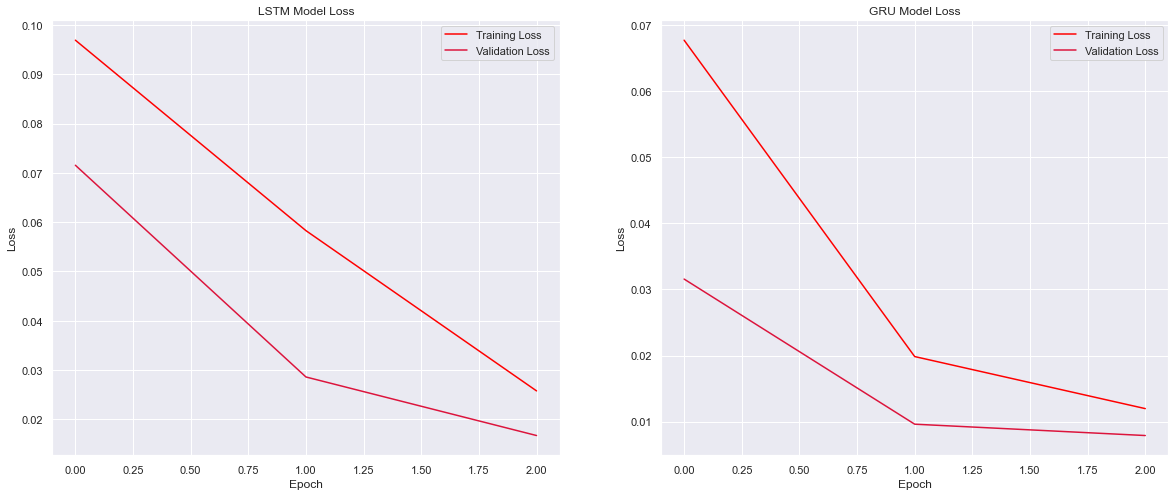

In [72]:

# summarize history for loss
fig, ax = plt.subplots(1,2, figsize=(20,8))
ax[0].plot(LSTM_history.history['loss'], color='red')
ax[0].plot(LSTM_history.history['val_loss'], color='crimson')
ax[0].set_title('LSTM Model Loss')
ax[0].set_ylabel('Loss')
ax[0].set_xlabel('Epoch')
ax[0].legend(['Training Loss', 'Validation Loss'], loc='upper right')

ax[1].plot(GRU_history.history['loss'], color='red')
ax[1].plot(GRU_history.history['val_loss'], color='crimson')
ax[1].set_title('GRU Model Loss')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epoch')
ax[1].legend(['Training Loss', 'Validation Loss'], loc='upper right')
plt.savefig("reduced_feature_images/training_loss_"+str(past_observation)+".png", dpi=1200)
plt.show()

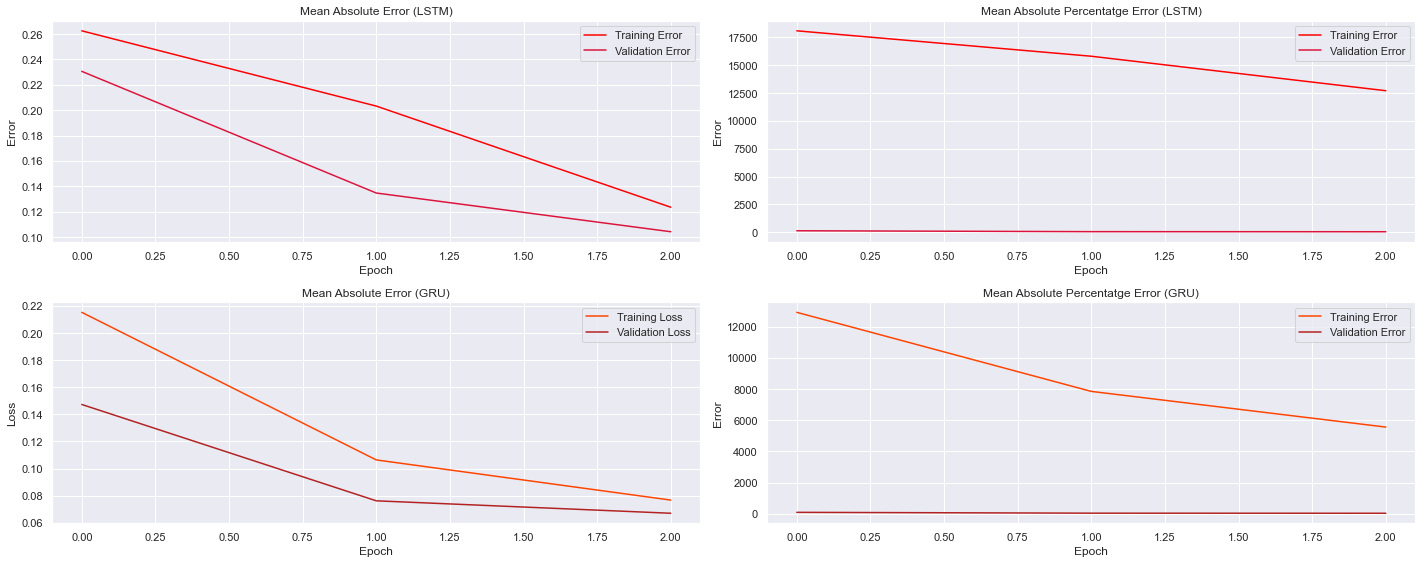

In [73]:
# summarize history for loss
fig, ax = plt.subplots(2,2, figsize=(20,8))
ax[0][0].plot(LSTM_history.history['mean_absolute_error'], color='red')
ax[0][0].plot(LSTM_history.history['val_mean_absolute_error'], color='crimson')
ax[0][0].set_title('Mean Absolute Error (LSTM)')
ax[0][0].set_ylabel('Error')
ax[0][0].set_xlabel('Epoch')
ax[0][0].legend(['Training Error', 'Validation Error'], loc='upper right')

ax[0][1].plot(LSTM_history.history['mean_absolute_percentage_error'], color='red')
ax[0][1].plot(LSTM_history.history['val_mean_absolute_percentage_error'], color='crimson')
ax[0][1].set_title('Mean Absolute Percentatge Error (LSTM)')
ax[0][1].set_ylabel('Error')
ax[0][1].set_xlabel('Epoch')
ax[0][1].legend(['Training Error', 'Validation Error'], loc='upper right')


ax[1][0].plot(GRU_history.history['mean_absolute_error'], color='orangered')
ax[1][0].plot(GRU_history.history['val_mean_absolute_error'], color='firebrick')
ax[1][0].set_title('Mean Absolute Error (GRU)')
ax[1][0].set_ylabel('Loss')
ax[1][0].set_xlabel('Epoch')
ax[1][0].legend(['Training Loss', 'Validation Loss'], loc='upper right')

ax[1][1].plot(GRU_history.history['mean_absolute_percentage_error'], color='orangered')
ax[1][1].plot(GRU_history.history['val_mean_absolute_percentage_error'], color='firebrick')
ax[1][1].set_title('Mean Absolute Percentatge Error (GRU)')
ax[1][1].set_ylabel('Error')
ax[1][1].set_xlabel('Epoch')
ax[1][1].legend(['Training Error', 'Validation Error'], loc='upper right')
fig.tight_layout()
plt.savefig("reduced_feature_images/mean_absolute_error_loss_"+str(past_observation)+".png", dpi=1200)
plt.show()

In [74]:
from tensorflow.keras.models import load_model
lstm_model = load_model('reduced_feature_model/model_lstm_'+str(past_observation)+'/')
gru_model = load_model('reduced_feature_model/model_gru_'+str(past_observation)+'/')

In [75]:
lstm_prediction = lstm_model.predict(X_test)
gru_prediction = gru_model.predict(X_test)

239/239 [==============================] - 2s 5ms/step


In [76]:
from tabnanny import verbose


lstm_evaluation = lstm_model.evaluate(X_test, y_test, verbose=0)
gru_evaluation = gru_model.evaluate(X_test, y_test, verbose=0)

In [77]:
(lstm_evaluation, gru_evaluation)

([0.017917294055223465, 0.1096038743853569, 81154.546875],
 [0.008622131310403347, 0.07039465010166168, 31295.81640625])

In [78]:
print(f'LSTM: Loss: {np.round(lstm_evaluation[0],4)}, Mean Absolute Error: {np.round(lstm_evaluation[1],4)}, MAPE: {np.round(lstm_evaluation[2],4)}')
print(f'GRU: Loss: {np.round(gru_evaluation[0],4)}, Mean Absolute Error: {np.round(gru_evaluation[1],4)}, MAPE: {np.round(gru_evaluation[2],4)}')

LSTM: Loss: 0.0179, Mean Absolute Error: 0.1096, MAPE: 81154.5469
GRU: Loss: 0.0086, Mean Absolute Error: 0.0704, MAPE: 31295.8164


In [79]:
lstm_Y = np.repeat(lstm_prediction, num_of_feature, axis=1)
lstm_y_inverse = sc_test.inverse_transform(lstm_Y)
gru_Y = np.repeat(gru_prediction, num_of_feature, axis=1)
gru_y_inverse = sc_test.inverse_transform(gru_Y)

In [80]:
Y_test = np.repeat(y_test, num_of_feature)
Y_test = Y_test.reshape(-1,num_of_feature)
Y_Test_transfer = sc_test.inverse_transform(Y_test)

In [81]:
lstm_Y_pred = lstm_y_inverse[:, num_of_feature-1]
gru_Y_pred = gru_y_inverse[:,num_of_feature-1]
actual_Y_test = Y_Test_transfer[:,num_of_feature-1 ]

In [82]:
def plot_series(time, series_true, series_pred, format='-', start=0, end=None):
    plt.plot(time[start:end], series_true[start:end],format)
    plt.plot(time[start:end], series_pred[start:end],format)
    plt.xlabel('Time')
    plt.ylabel('Traffic Volume')
    plt.grid(True)
    plt.show()

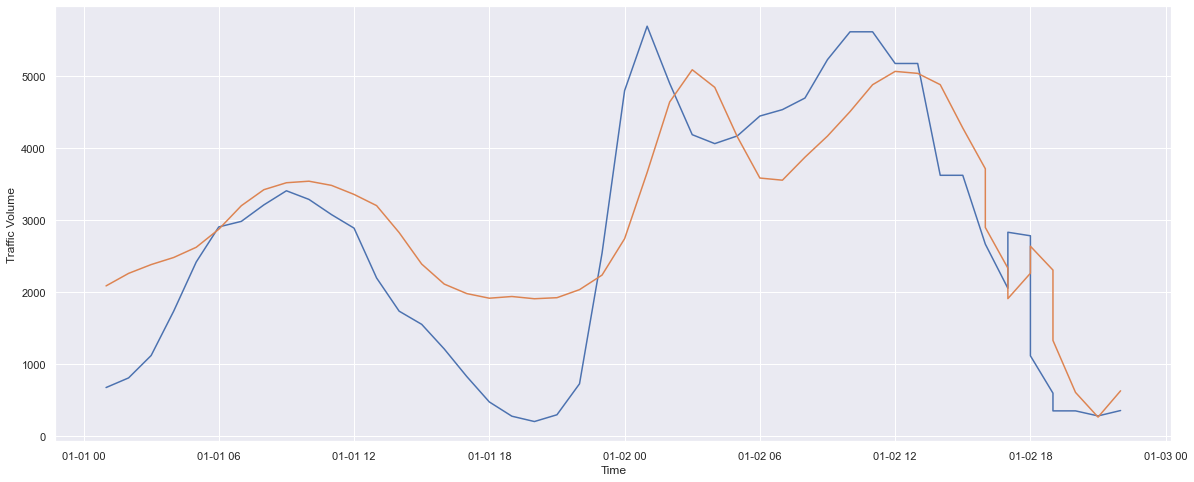

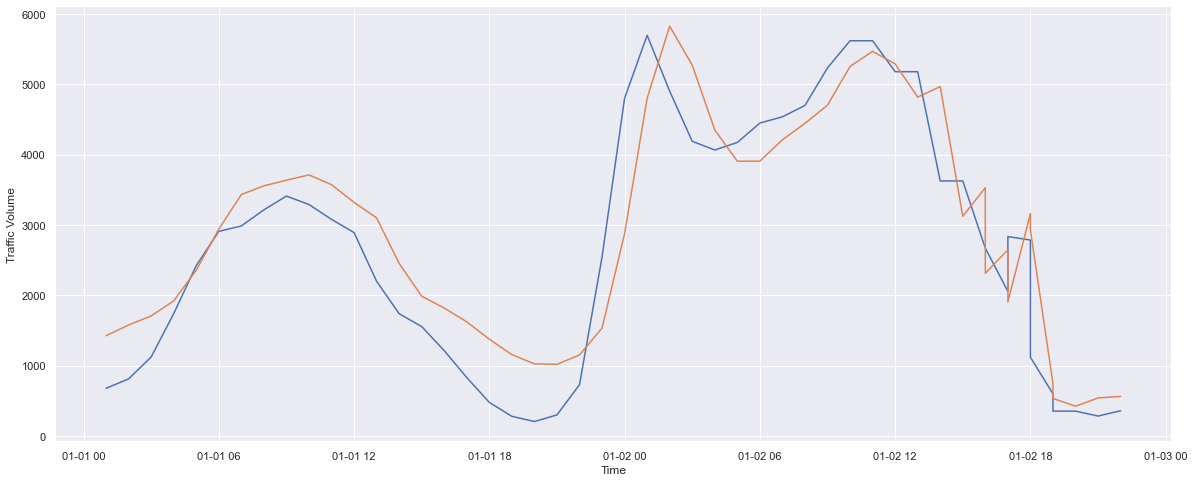

In [83]:
lstm_y_pred = np.array(lstm_Y_pred)
gru_y_pred = np.array(gru_Y_pred)
y_true = np.array(actual_Y_test)

time_test = np.array(test_time)

plt.figure(figsize=(20,8))
plot_series(time_test[:50], y_true[:50],lstm_y_pred[:50])
plt.figure(figsize=(20,8))
plot_series(time_test[:50], y_true[:50],gru_y_pred[:50])

In [84]:
def plot_series_subplot(time, series_true, series_pred, ax,title="",format='-', start=0, end=None):
    xlabels = [str(time[i])[0:13] for i in range(len(time))]
    ax.plot(time[start:end], series_true[start:end],format)
    ax.plot(time[start:end], series_pred[start:end],format)
    ax.set_xlabel('Time')
    ax.set_title(title)
    #ax.set_xticks(time[start:end])
    ax.set_xticklabels(xlabels, rotation=50)
    ax.legend(['Actual','Predicted'], loc='best')
    ax.set_ylabel('Traffic Volume')
    ax.grid(True)

C:\Users\Won's Lab\AppData\Local\Temp\ipykernel_27312\2374997822.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xlabels, rotation=50)


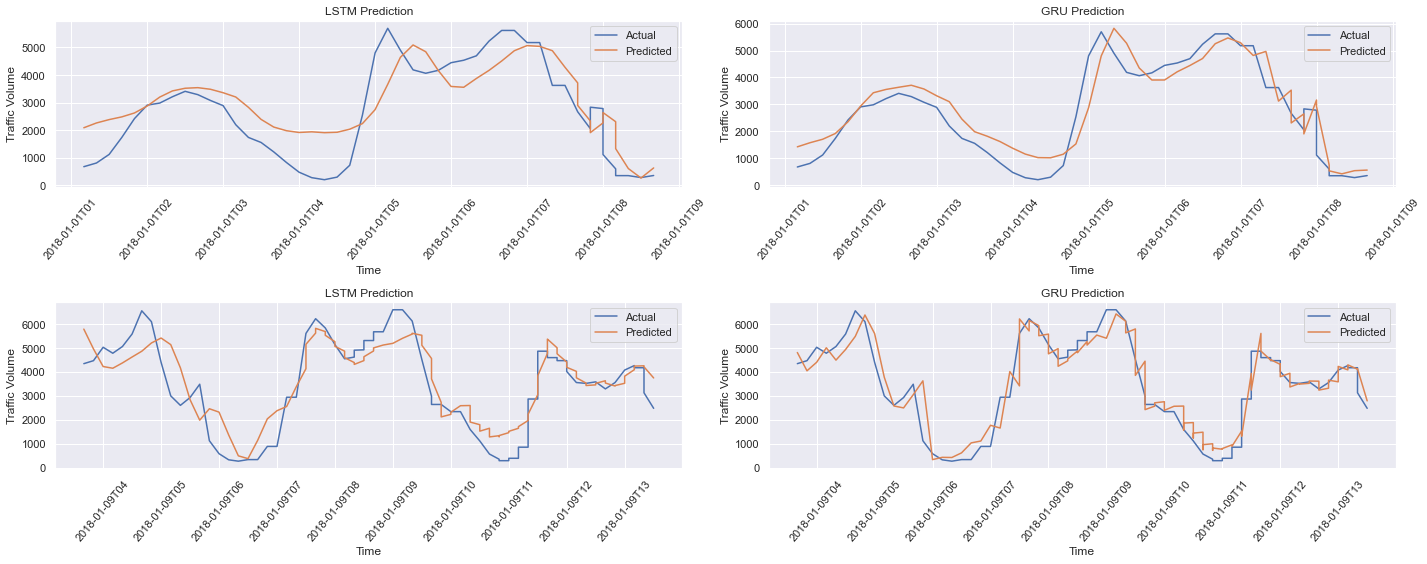

In [85]:
fig, ax = plt.subplots(2,2, figsize=(20,10))
plot_series_subplot(time_test[:50], y_true[:50],lstm_y_pred[:50],ax[0][0], "LSTM Prediction")
#plt.figure(figsize=(20,8))
plot_series_subplot(time_test[:50], y_true[:50],gru_y_pred[:50], ax[0][1],"GRU Prediction")
plot_series_subplot(time_test[200:300], y_true[200:300],lstm_y_pred[200:300],ax[1][0], "LSTM Prediction")
plot_series_subplot(time_test[200:300], y_true[200:300],gru_y_pred[200:300], ax[1][1],"GRU Prediction")
fig.tight_layout()
plt.savefig("reduced_feature_images/prediction_0_"+str(past_observation)+".png", dpi=1200)

C:\Users\Won's Lab\AppData\Local\Temp\ipykernel_27312\2374997822.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xlabels, rotation=50)


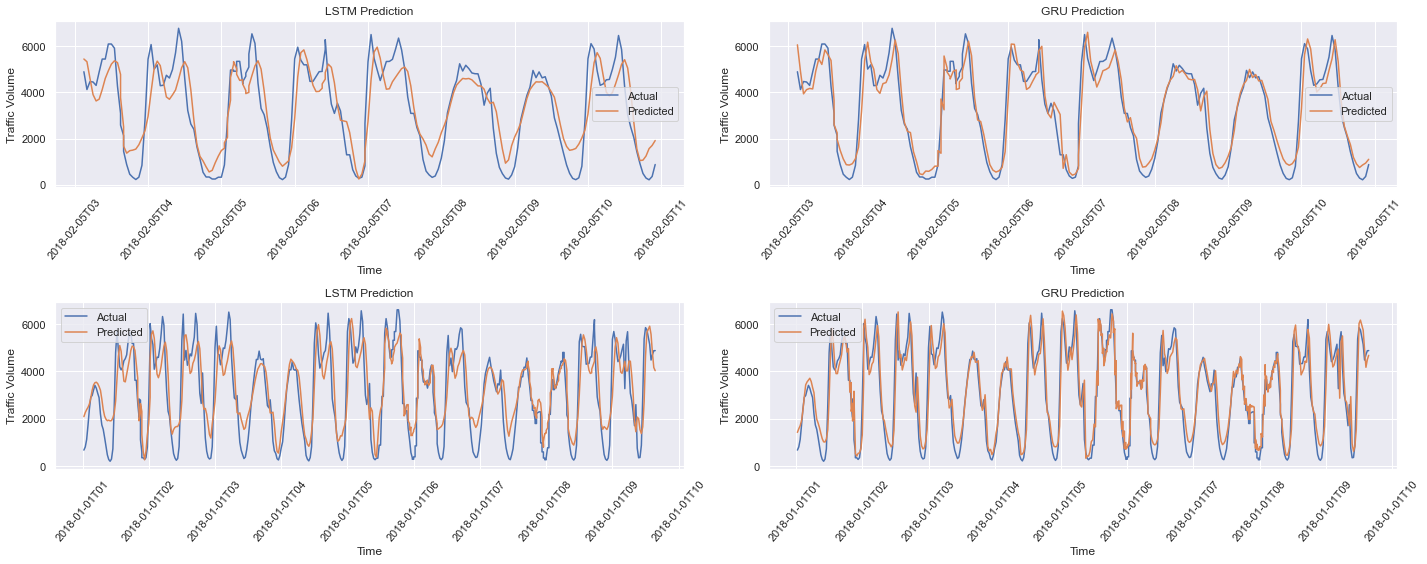

In [86]:
fig, ax = plt.subplots(2,2, figsize=(20,10))
plot_series_subplot(time_test[1000:1200], y_true[1000:1200],lstm_y_pred[1000:1200],ax[0][0], "LSTM Prediction")
plot_series_subplot(time_test[1000:1200], y_true[1000:1200],gru_y_pred[1000:1200], ax[0][1],"GRU Prediction")

plot_series_subplot(time_test[0:500], y_true[0:500],lstm_y_pred[0:500],ax[1][0], "LSTM Prediction")
plot_series_subplot(time_test[0:500], y_true[0:500],gru_y_pred[0:500], ax[1][1],"GRU Prediction")
fig.tight_layout()
plt.savefig("reduced_feature_images/prediction_1_"+str(past_observation)+".png", dpi=1200)

C:\Users\Won's Lab\AppData\Local\Temp\ipykernel_27312\2374997822.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xlabels, rotation=50)


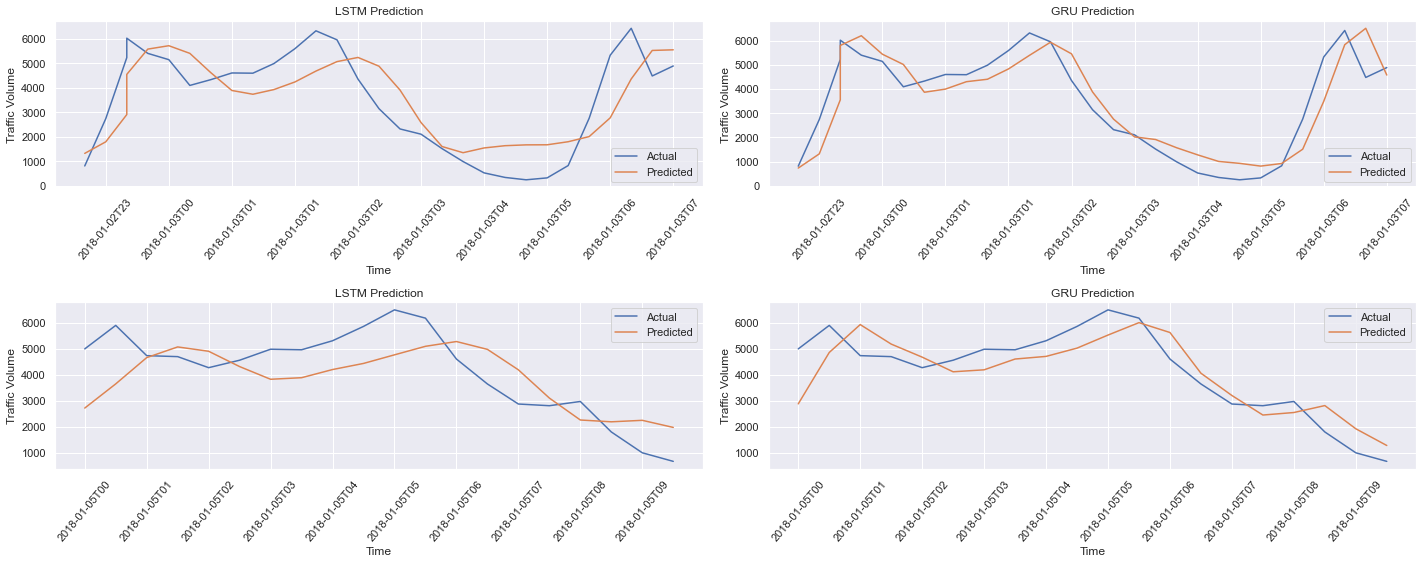

In [87]:
fig, ax = plt.subplots(2,2, figsize=(20,10))
plot_series_subplot(time_test[50:80], y_true[50:80],lstm_y_pred[50:80],ax[0][0], "LSTM Prediction")
plot_series_subplot(time_test[50:80], y_true[50:80],gru_y_pred[50:80], ax[0][1],"GRU Prediction")

plot_series_subplot(time_test[100:120], y_true[100:120],lstm_y_pred[100:120],ax[1][0], "LSTM Prediction")
plot_series_subplot(time_test[100:120], y_true[100:120],gru_y_pred[100:120], ax[1][1],"GRU Prediction")
fig.tight_layout()
plt.savefig("reduced_feature_images/prediction_2_"+str(past_observation)+".png", dpi=1200)

C:\Users\Won's Lab\AppData\Local\Temp\ipykernel_27312\2374997822.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xlabels, rotation=50)


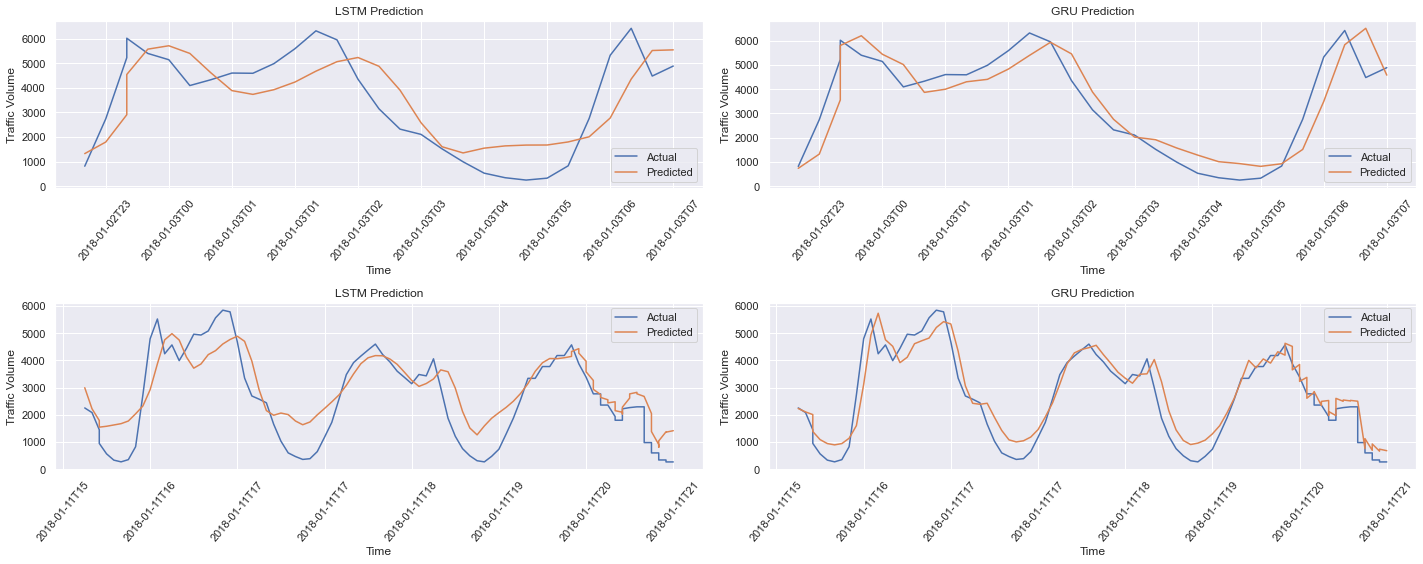

In [88]:
fig, ax = plt.subplots(2,2, figsize=(20,10))
plot_series_subplot(time_test[50:80], y_true[50:80],lstm_y_pred[50:80],ax[0][0], "LSTM Prediction")
plot_series_subplot(time_test[50:80], y_true[50:80],gru_y_pred[50:80], ax[0][1],"GRU Prediction")

plot_series_subplot(time_test[300:400], y_true[300:400],lstm_y_pred[300:400],ax[1][0], "LSTM Prediction")
plot_series_subplot(time_test[300:400], y_true[300:400],gru_y_pred[300:400], ax[1][1],"GRU Prediction")
fig.tight_layout()
plt.savefig("reduced_feature_images/prediction_3_"+str(past_observation)+".png", dpi=1200)